[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/blankazselyke/DL_NHF/blob/main/DL_NHF.ipynb)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from google.colab import userdata
import tensorflow as tf
import os
import cv2

In [4]:
os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

In [5]:
# Download data
!kaggle competitions download -c airbus-ship-detection

100% 28.6G/28.6G [06:36<00:00, 154MB/s]
100% 28.6G/28.6G [06:36<00:00, 77.5MB/s]


In [6]:
# Unzip data
!unzip airbus-ship-detection.zip

A streamkimeneten csak az utolsó 5000 sor látható.
  inflating: train_v2/f9775b70e.jpg  
  inflating: train_v2/f977a470c.jpg  
  inflating: train_v2/f9780bfaf.jpg  
  inflating: train_v2/f9782bdfe.jpg  
  inflating: train_v2/f9785ca49.jpg  
  inflating: train_v2/f9785e462.jpg  
  inflating: train_v2/f97a719d5.jpg  
  inflating: train_v2/f97afa376.jpg  
  inflating: train_v2/f97b85e3e.jpg  
  inflating: train_v2/f97bd0b11.jpg  
  inflating: train_v2/f97bd6b80.jpg  
  inflating: train_v2/f97bfb1b2.jpg  
  inflating: train_v2/f97c8cbbe.jpg  
  inflating: train_v2/f97cdd397.jpg  
  inflating: train_v2/f97d92e1e.jpg  
  inflating: train_v2/f97da9e70.jpg  
  inflating: train_v2/f97e843d3.jpg  
  inflating: train_v2/f97e961f2.jpg  
  inflating: train_v2/f97e96c68.jpg  
  inflating: train_v2/f97f63ae1.jpg  
  inflating: train_v2/f97f80839.jpg  
  inflating: train_v2/f97f83438.jpg  
  inflating: train_v2/f97fab9ad.jpg  
  inflating: train_v2/f97fd4915.jpg  
  inflating: train_v2/f9801bc03.jpg  

In [7]:
!rm /content/airbus-ship-detection.zip

In [8]:
# Set the file path
file_path = "/content/train_ship_segmentations_v2.csv"

# Read the CSV file
data = pd.read_csv(file_path)

# Display the first few rows of the data
print(data.head())

         ImageId                                      EncodedPixels
0  00003e153.jpg                                                NaN
1  0001124c7.jpg                                                NaN
2  000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...
3  000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...
4  000194a2d.jpg  51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


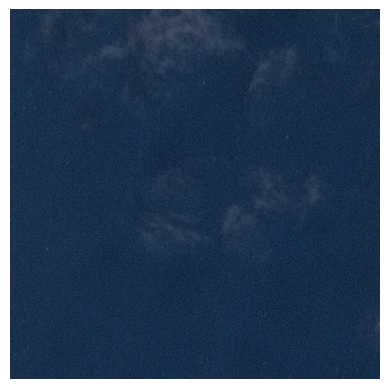

Displaying image 00003e153.jpg


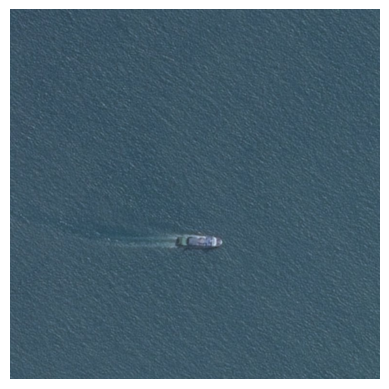

Displaying image 000155de5.jpg


In [9]:
# Diplaying an image
def display_image(image_name):
    img = plt.imread(f'/content/train_v2/{image_name}')
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    print("Displaying image " + image_name)

# Display an image without a ship
display_image(data['ImageId'][0])
# Display an image with a ship
display_image(data['ImageId'][2])

In [10]:
# Function for converting rle masks to binary masks
def rle_decode(mask_rle, shape=(768, 768)):

    # Check if mask_rle is NaN or None
    if pd.isna(mask_rle):
        return np.zeros((shape[0], shape[1]), dtype=np.uint8)

    # Split the mask_rle string by spaces to separate start and length values
    s = mask_rle.split()

    # Convert the start and length values to integer arrays
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0::2], s[1::2])]

    # Adjust start values to zero-based indexing
    starts -= 1

    # Calculate end positions by adding start and length values
    ends = starts + lengths

    # Create a flat image array filled with zeros
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)

    # Set pixels between start and end positions to 1 for each segment
    for start, end in zip(starts, ends):
        img[start:end] = 1

    # Reshape the flat array to the given shape and transpose it
    return img.reshape(shape).T


In [11]:
# Sample for decoding
# Decode the image with ship
sample_image = data['ImageId'][2]
sample_mask_rle = data[data['ImageId'] == sample_image]['EncodedPixels'].iloc[0]
sample_mask_decoded = rle_decode(sample_mask_rle)

In [12]:
# This is the original mask
sample_mask_rle

'264661 17 265429 33 266197 33 266965 33 267733 33 268501 33 269269 33 270037 33 270805 33 271573 33 272341 33 273109 33 273877 33 274645 33 275413 33 276181 33 276949 33 277716 34 278484 34 279252 33 280020 33 280788 33 281556 33 282324 33 283092 33 283860 33 284628 33 285396 33 286164 33 286932 33 287700 33 288468 33 289236 33 290004 33 290772 33 291540 33 292308 33 293076 33 293844 33 294612 33 295380 33 296148 33 296916 33 297684 33 298452 33 299220 33 299988 33 300756 33 301524 33 302292 33 303060 33 303827 34 304595 34 305363 33 306131 33 306899 33 307667 33 308435 33 309203 33 309971 33 310739 33 311507 33 312275 33 313043 33 313811 33 314579 33 315347 33 316115 33 316883 33 317651 33 318419 33 319187 33 319955 33 320723 33 321491 33 322259 33 323027 33 323795 33 324563 33 325331 33 326099 33 326867 33 327635 33 328403 33 329171 33 329938 34 330706 34 331474 33 332242 33 333010 33 333778 33 334546 33 335314 33 336082 33 336850 33 337618 33 338386 33 339154 33 339922 33 340690 33

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
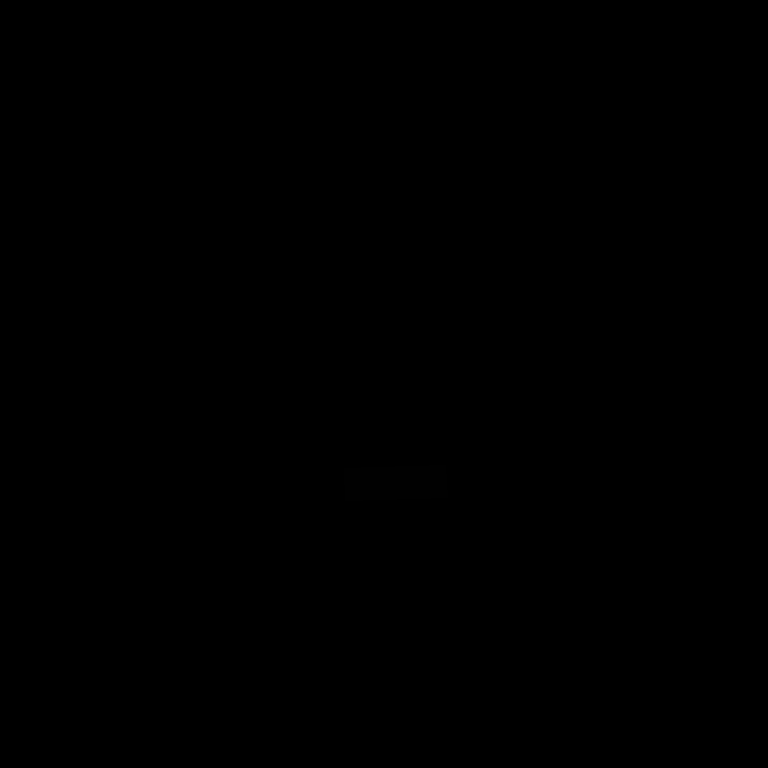

In [13]:
# This is the decoded binary mask
sample_mask_decoded

In [14]:
# It is hard to find the ones, but we can check like this
# Number of ones
num_ones = np.sum(sample_mask_decoded == 1)
print("Number of 1's in the mask:", num_ones)

Number of 1's in the mask: 3388


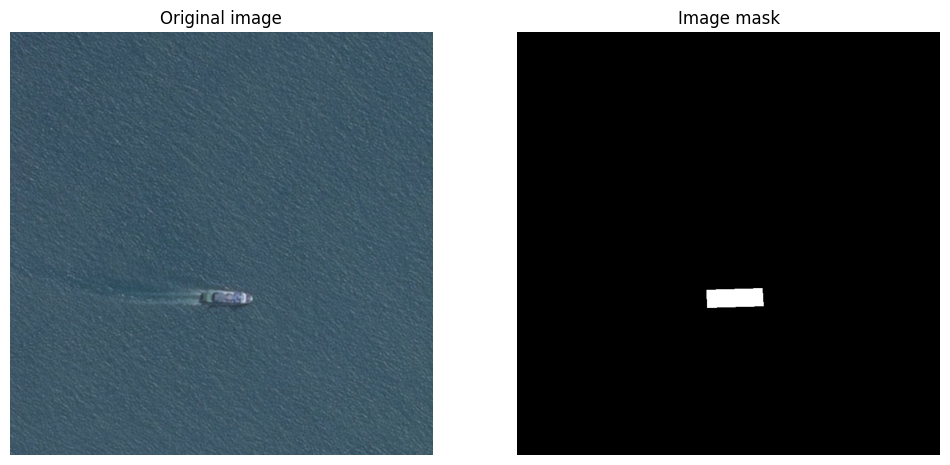

In [15]:
# Visualizing the mask
def display_image_with_mask(image_name, mask_rle):
    img = plt.imread(f'/content/train_v2/{image_name}')
    mask = rle_decode(mask_rle)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title('Original image')

    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='gray')
    plt.axis('off')
    plt.title('Image mask')
    plt.show()


display_image_with_mask(sample_image, sample_mask_rle)


In [16]:
# When there are multiple ships, multiple masks belong to one image, so we gather the unique ids
ids = np.unique(data['ImageId'])

In [17]:

image_directory = '/content/train_v2/'

# Image loading
def load_image(img_id):
    image = tf.io.read_file(img_id)
    image = tf.image.decode_jpeg(image)
    image = tf.cast(image, tf.float32) / 255.0  # Normalize
    return image

# Create dataset
image_dataset = tf.data.Dataset.list_files([os.path.join(image_directory, img_id) for img_id in ids], shuffle=False)
image_dataset = image_dataset.map(lambda x: load_image(x))
image_dataset = image_dataset.batch(64)  # Batch size
image_dataset = image_dataset.prefetch(tf.data.AUTOTUNE)  # Prefetch optimalization



In [18]:
mask_directory = '/content/train_masks/'
os.makedirs('/content/train_masks', exist_ok=True)
# Mask saving function
def save_mask(img_id):
    masks_for_id = data[data['ImageId'] == img_id]['EncodedPixels'].tolist()

    decoded_masks = []
    for mask in masks_for_id:
        decoded_masks.append(rle_decode(mask))



    if decoded_masks:
    # Combine multiple masks to one mask
      combined_mask = np.maximum.reduce(decoded_masks)
      combined_mask = (combined_mask * 255).astype(np.uint8)


    else: # If there is no mask for the current image we create an empty mask
      combined_mask = np.zeros((768, 768), dtype=np.uint8)
    cv2.imwrite(f'/content/train_masks/{img_id}', combined_mask)
    return


# Mask loading function
def load_mask(img_id):
    image = tf.io.read_file(img_id)
    image = tf.image.decode_jpeg(image)
    image = tf.cast(image, tf.float32) / 255.0  # Normalize
    return image


for img_id in ids:
    save_mask(img_id)

# Create dataset
mask_dataset = tf.data.Dataset.list_files([os.path.join(mask_directory, img_id) for img_id in ids], shuffle=False)
mask_dataset = mask_dataset.map(lambda x: load_mask(x))

mask_dataset = mask_dataset.batch(64)  # Batch size
mask_dataset = mask_dataset.prefetch(tf.data.AUTOTUNE)  # Prefetch optimalization


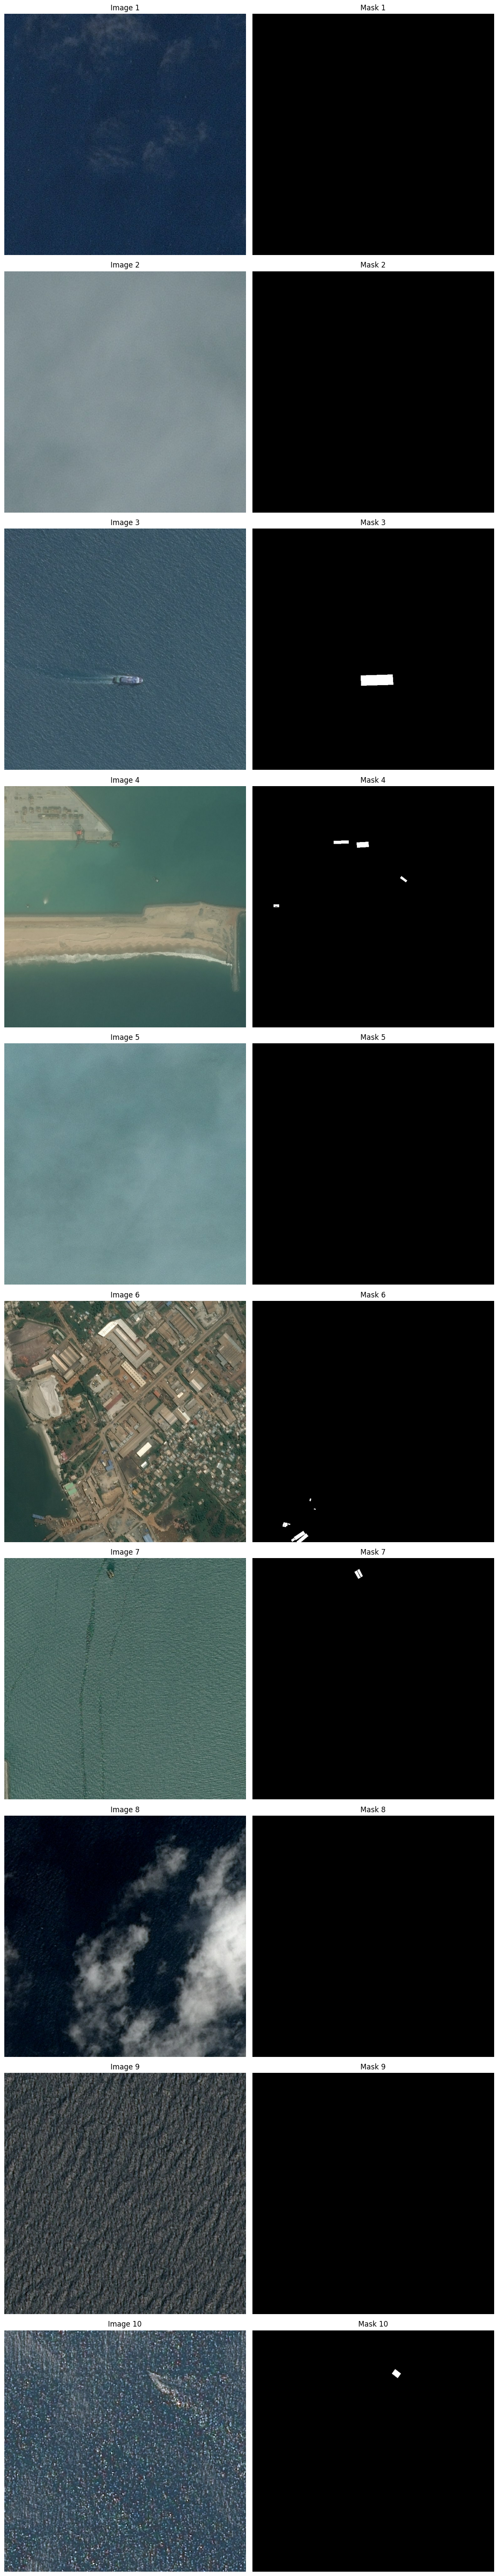

In [19]:
# Visualize combined masks

# Number of images to display
num_images_to_display = 10

# Create a figure with subplots
fig, axes = plt.subplots(num_images_to_display, 2, figsize=(12, 6 * num_images_to_display))

X = image_dataset.take(1).as_numpy_iterator().next()
Y = mask_dataset.take(1).as_numpy_iterator().next()

for i in range(num_images_to_display):
    # Plot the image

    axes[i, 0].imshow(X[i], cmap='gray')
    axes[i, 0].set_title(f'Image {i + 1}')
    axes[i, 0].axis('off')

    # Plot the corresponding mask
    axes[i, 1].imshow(Y[i], cmap='gray')
    axes[i, 1].set_title(f'Mask {i + 1}')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

In [20]:
# Prepare the dataset for training

# Train: 80%
# Test : 10%
# Validation: 10%

dataset = tf.data.Dataset.zip((image_dataset, mask_dataset))

total_size = len(dataset)
train_count = int(total_size * 0.8)
val_count = int(total_size * 0.1)

# Split the dataset into two subsets (80% train, 20% other)
train_dataset = dataset.take(train_count)
remaining_dataset = dataset.skip(train_count)


# Split the remaining 20% int two datasets: validation an test set
val_dataset = remaining_dataset.take(val_count)
test_dataset = remaining_dataset.skip(val_count)

In [21]:
# Check if the split was correct

print(f'Train batches: {len(train_dataset)}')
print(f'Validation batches: {len(val_dataset)}')
print(f'Test batches: {len(test_dataset)}')


Train batches: 2407
Validation batches: 300
Test batches: 302
